In [11]:
import polars as pl
import matplotlib.pyplot as plt

import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 100

In [12]:
from pathlib import Path
base = Path.cwd()
path = base / 'cases' / 'gdp-ppp.csv'
if not path.exists():
    path = base.parent / 'cases' / 'gdp-ppp.csv'

# skip metadata lines before the header
data = pl.read_csv(
    path,
    skip_rows=4,                 # skip metadata lines
    null_values=["", ".."],      # treat empty strings and '..' as nulls
    infer_schema_length=0        # full-file inference for mixed year columns
)

# strip whitespace in column names
data = data.rename({c: c.strip() for c in data.columns})
# keep only the gdp ppp indicator rows (defensive)
if 'Indicator Code' in data.columns:
    data = data.filter(pl.col('Indicator Code') == 'NY.GDP.MKTP.PP.CD')

In [13]:
def normalize_data(df: pl.DataFrame) -> pl.DataFrame:
    # identify country and year columns
    id_cols = [c for c in ['Country Name', 'Country Code'] if c in df.columns]
    year_cols = [c for c in df.columns if c.isdigit()]
    # unpivot years to long
    long = df.unpivot(index=id_cols, variable_name='year', value_name='value')
    # cast and clean
    long = long.with_columns([
        pl.col('year').cast(pl.Int64, strict=False),
        pl.when(pl.col('value').cast(pl.Float64, strict=False).is_not_null())
          .then(pl.col('value').cast(pl.Float64, strict=False))
          .otherwise(None)
          .alias('value')
    ]).drop_nulls(subset=['year'])
    # convert to trillions, ignoring nulls
    long = long.with_columns((pl.col('value') / 1e12).alias('value'))
    # pivot back to wide by country
    key_col = 'Country Name' if 'Country Name' in id_cols else id_cols[0]
    wide = long.pivot(index='year', on=key_col, values='value').sort('year')
    return wide

In [14]:
## we can query for some data and normalize it and plot it
# data_top5 = data.filter(pl.col('Country Name').is_in(["China", "Germany", "India", "Japan", "United States"]))
# gdp_top5 = normalize_data(data_top5)
# for col in ["China", "Germany", "India", "Japan", "United States"]:
#     plt.plot(gdp_top5['year'], gdp_top5[col], label=col)
# plt.legend(); plt.title('GDP Tops'); plt.xlabel('year'); plt.ylabel('trillion dollars')

## or we can normalize all the data and plot it
gdp = normalize_data(data)
# plt.figure(figsize=(10,5)); plt.plot(gdp['year'], gdp['China']); plt.title('GDP Total'); plt.xlabel('year'); plt.ylabel('trillion dollars')

In [15]:
# add sum of G7/BRICS countries as new columns (row-wise sums)
g7 = ['Canada', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States']
brics = ['Brazil', 'Russian Federation', 'India', 'China', 'South Africa']

# compute sums using row-wise sum
gdp = gdp.with_columns([
    pl.sum_horizontal([pl.col(c) for c in g7]).alias('G7'),
    pl.sum_horizontal([pl.col(c) for c in brics]).alias('BRICS'),
])

In [16]:
def plot_data(df: pl.DataFrame, title, xlabel, ylabel):
    # expect df to contain a 'year' column and value columns to plot
    value_cols = [c for c in df.columns if c != 'year']
    plt.figure(figsize=(10,5))
    for col in value_cols:
        plt.plot(df['year'], df[col], label=col)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().set_xmargin(0)
    plt.minorticks_on()
    plt.grid(True, which='both', linewidth=0.5, linestyle='--', color='gray')
    plt.grid(True, which='minor', linewidth=0.2, linestyle=':', color='gray')
    plt.legend()
    plt.show()

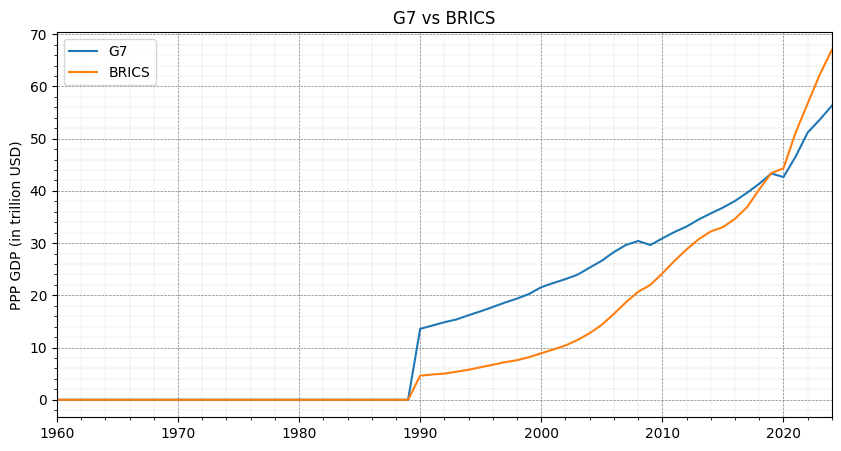

In [17]:
# plot the percentage of G7 and BRICS
plot_data(gdp.select(['year', 'G7', 'BRICS']), 'G7 vs BRICS', '', 'PPP GDP (in trillion USD)')

In [18]:
## due to the structure of World Bank data, we cannot simply sum all columns to get the total GDP, we should use the 'World' column instead
# gdp['Total'] = gdp.sum(axis=1)

# add G7 percentage of world GDP as new column
gdp = gdp.with_columns([
    (pl.col('G7') / pl.col('World') * 100).alias('G7 %'),
    (pl.col('BRICS') / pl.col('World') * 100).alias('BRICS %'),
])

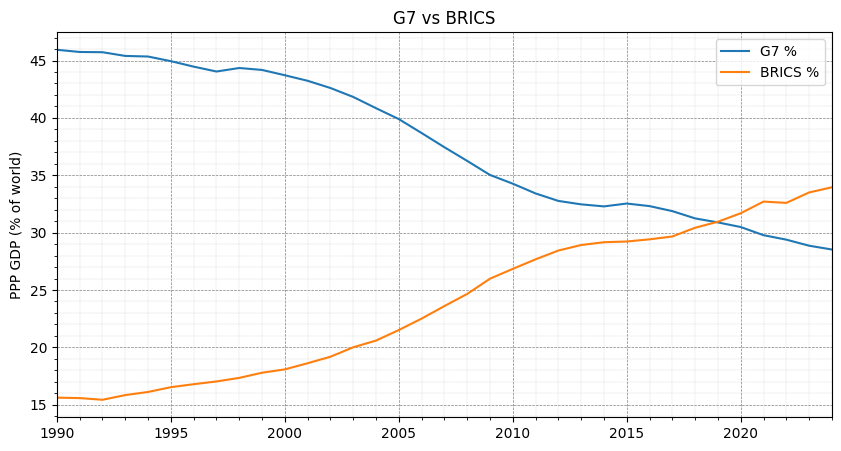

In [19]:
# plot the percentage of G7 and BRICS
plot_data(gdp.select(['year', 'G7 %', 'BRICS %']), 'G7 vs BRICS', '', 'PPP GDP (% of world)')